In [40]:
# --- Импорты ---
import os
import datetime
import multiprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import requests

import torchvision
import torchvision.utils as vutils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# --- Гиперпараметры обучения и модели ---
BATCH_SIZE = 128
# Размер пакета данных для одной итерации обучения.
# Большее значение ускоряет обучение, но требует больше видеопамяти.
LATENT_DIM = 128
# Размерность латентного пространства (вектора z).
# Чем больше размерность, тем богаче потенциальная вариативность генерируемых изображений.
IMAGE_SIZE = 128
# Размер входных изображений (высота и ширина в пикселях).
# Должен быть кратным 16 для корректной работы архитектуры энкодера и декодера.
EPOCHS = 30
# Общее количество проходов по всему датасету во время обучения.
LEARNING_RATE = 1e-3
# Скорость обучения оптимизатора.
# Малое значение приводит к медленному обучению, большое может вызывать нестабильность.
SAVE_PATH = './models/vae_model.pth'
# Путь для сохранения финальной версии обученной модели.
BEST_MODEL_PATH = './models/vae_best_model.pth'
# Путь для сохранения лучшей модели (по минимальному значению лосса на обучении).
SAVE_INTERVAL = 50
# Интервал в эпохах для сохранения сгенерированных изображений в процессе обучения.
OLD_MODEL = False
# Путь к ранее обученной модели для продолжения обучения или генерации изображений.
# False означает обучение \"с нуля\".

In [21]:
#Folders
OUTPUT = './output'
EPOCHS_FOLDER = os.path.join(OUTPUT, 'epochs')
GENERATED_FOLDER = os.path.join(OUTPUT, 'generated')
MORPH_FOLDER = os.path.join(OUTPUT, 'morph_frames')
Z_FOLDER = os.path.join(OUTPUT, 'z_frames')
LAT_GRID = os.path.join(OUTPUT, 'latent_frames')
GRID_FOLDER = os.path.join(OUTPUT, 'grid')
os.makedirs(OUTPUT, exist_ok=True)
os.makedirs(EPOCHS_FOLDER, exist_ok=True)
os.makedirs(GENERATED_FOLDER, exist_ok=True)
os.makedirs(MORPH_FOLDER, exist_ok=True)
os.makedirs(Z_FOLDER, exist_ok=True)
os.makedirs(LAT_GRID, exist_ok=True)
os.makedirs(GRID_FOLDER, exist_ok=True)

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using DEVICE: {DEVICE}")

Using DEVICE: cuda


In [6]:
# Подготовка данных
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

In [ ]:
# Создание загрузчиков данных
num_workers = min(16, multiprocessing.cpu_count())
prefetch_factor = 128#* 2

In [ ]:
dataset = datasets.ImageFolder(root='data', transform=transform)
#dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # обязательно перемешивание
    num_workers=num_workers,           # или другое оптимальное число
    pin_memory=True,
    prefetch_factor=prefetch_factor,       # если много CPU
    persistent_workers=True  # если поддерживается версией
)

print(f"Loaded {len(dataset)} images from 'data'")

Loaded 1800 images from 'data'


In [8]:
# Определение модели
class Encoder(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        assert img_size % 16 == 0, "IMAGE_SIZE должно быть кратно 16"
        num_layers = int(torch.log2(torch.tensor(img_size // 4)))
        layers = []
        in_channels = 3
        for _ in range(num_layers):
            out_channels = in_channels * 2
            layers.append(nn.Conv2d(in_channels, out_channels, 4, 2, 1))
            layers.append(nn.ReLU())
            in_channels = out_channels
        self.conv = nn.Sequential(*layers)
        self.fc_mu = nn.Linear(in_channels * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(in_channels * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        assert img_size % 16 == 0, "IMAGE_SIZE должно быть кратно 16"
        num_layers = int(torch.log2(torch.tensor(img_size // 4)))
        self.start_channels = 3 * (2 ** num_layers)
        self.fc = nn.Linear(latent_dim, self.start_channels * 4 * 4)
        layers = []
        in_channels = self.start_channels
        for _ in range(num_layers):
            out_channels = in_channels // 2
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1))
            layers.append(nn.ReLU())
            in_channels = out_channels
        layers[-2] = nn.ConvTranspose2d(in_channels * 2, 3, 4, 2, 1)
        layers[-1] = nn.Sigmoid()
        self.deconv = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, self.start_channels, 4, 4)
        x = self.deconv(x)
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        self.encoder = Encoder(latent_dim, img_size)
        self.decoder = Decoder(latent_dim, img_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [9]:
# Вспомогательные функции
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

def plot_loss(losses):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('График изменения потерь')
    plt.legend()
    plt.show()

def imshow(img):
    img = np.array(img)
    if img.min() < 0:
        img -= img.min()
        img /= img.max()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [10]:
# Инициализация модели
vae = VAE(LATENT_DIM, IMAGE_SIZE).to(DEVICE)
if OLD_MODEL:
    vae.load_state_dict(torch.load(OLD_MODEL, map_location=DEVICE))
    print("Loaded model from", OLD_MODEL)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

In [11]:
# Обучение модели
losses = []
best_loss = float('inf')

In [ ]:
for epoch in range(EPOCHS):
    tstart = datetime.datetime.now()
    vae.train()
    train_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.to(DEVICE)
        optimizer.zero_grad()
        recon_imgs, mu, logvar = vae(imgs)
        loss = loss_function(recon_imgs, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(dataset)
    losses.append(avg_loss)

    print(f"\nEpoch [{epoch + 1}/{EPOCHS}], Train Loss: {avg_loss:.4f}")
    print(f"Время: {str(datetime.datetime.now() - tstart).split('.')[0]}")
    # Сохраняем лучшую модель
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model = vae
    else:
        print(f"val_loss: {avg_loss:.4f} > best_loss: {best_loss:.4f}") # , попытка {patience_counter}
    # Периодически генерируем изображения
    if (epoch + 1) % SAVE_INTERVAL == 0:
        vae.eval()
        with torch.no_grad():
            z = torch.randn(4, LATENT_DIM).to(DEVICE)
            samples = vae.decoder(z)
        vutils.save_image(samples.cpu(), f'{EPOCHS_FOLDER}/generated_faces_epoch_{epoch+1}.png', nrow=4)
        #imshow(torchvision.utils.make_grid(samples.cpu()))

Epoch [1/30] - Loss: 4376.4840
New best model saved at epoch 1 with loss 4376.4840
Epoch [2/30] - Loss: 3350.4290
New best model saved at epoch 2 with loss 3350.4290
Epoch [3/30] - Loss: 2102.7418
New best model saved at epoch 3 with loss 2102.7418
Epoch [4/30] - Loss: 1524.1420
New best model saved at epoch 4 with loss 1524.1420
Epoch [5/30] - Loss: 1382.2953
New best model saved at epoch 5 with loss 1382.2953
Epoch [6/30] - Loss: 1334.9151
New best model saved at epoch 6 with loss 1334.9151
Epoch [7/30] - Loss: 1305.8617
New best model saved at epoch 7 with loss 1305.8617
Epoch [8/30] - Loss: 1291.9511
New best model saved at epoch 8 with loss 1291.9511
Epoch [9/30] - Loss: 1275.9274
New best model saved at epoch 9 with loss 1275.9274
Epoch [10/30] - Loss: 1257.7659
New best model saved at epoch 10 with loss 1257.7659
Epoch [11/30] - Loss: 1239.8811
New best model saved at epoch 11 with loss 1239.8811
Epoch [12/30] - Loss: 1227.8949
New best model saved at epoch 12 with loss 1227.894

In [ ]:
# Сохранение финальной модели
torch.save(best_model.state_dict(), SAVE_PATH)
print(f"Final model saved to {SAVE_PATH}")

Final model saved to ./models/vae_model.pth


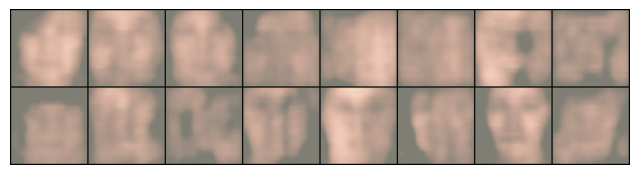

In [22]:
# Генерация итоговых лиц
vae.eval()
with torch.no_grad():
    z = torch.randn(16, LATENT_DIM).to(DEVICE)
    samples = vae.decoder(z)
vutils.save_image(samples.cpu(), f'{GENERATED_FOLDER}/generated_faces_final.png', nrow=4)
imshow(torchvision.utils.make_grid(samples.cpu()))

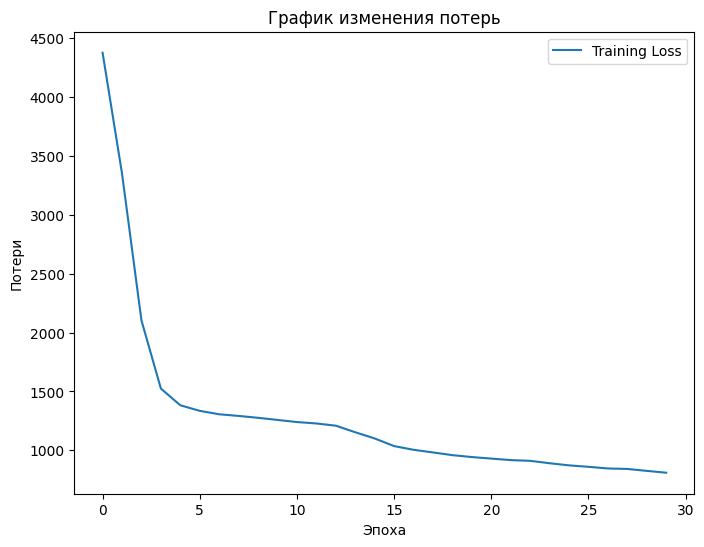

In [23]:
# Построение графика потерь
plot_loss(losses)

In [ ]:
# Уведомление о завершении обучения
url = "http://home.teyhd.ru:3334/"
params = {"msg": f"Обучение Автоэнкодера завершено: Эпох {EPOCHS}\nФинальный лосс: {losses[-1]:.6f}"}
try:
    response = requests.get(url, params=params)
    print(f"Notification sent! Status Code: {response.status_code} | Response Text: {response.text}")
except Exception as e:
    print(f"Failed to send notification: {e}")

Notification sent! Status Code: 200 | Response Text: SENDING


### Генерация разных типов z для декодера и создание GIF морфинга

In [26]:
# --- Настройки ---
NUM_PIC = 16  # Количество изображений

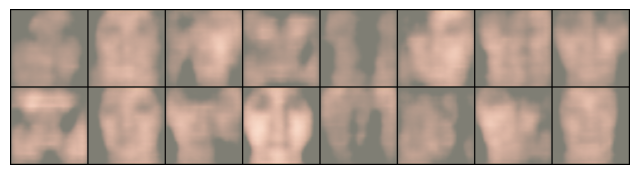

In [27]:
# --- 1. Стандартное сэмплирование (N(0,1)) ---
with torch.no_grad():
    z = torch.randn(NUM_PIC, LATENT_DIM).to(DEVICE)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{Z_FOLDER}/z_random_normal.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

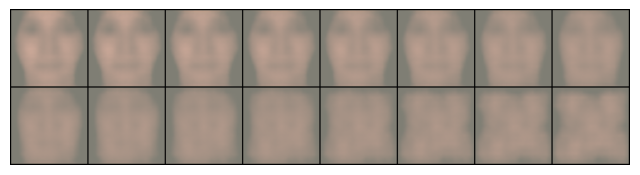

In [28]:
# --- 2. Ручное задание признаков ---
with torch.no_grad():
    z = torch.zeros(NUM_PIC, LATENT_DIM).to(DEVICE)
    z[:, :2] = torch.linspace(-3, 3, NUM_PIC).unsqueeze(1).repeat(1, 2)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{Z_FOLDER}/z_manual_features.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

In [29]:
# --- 3. Латентные коды реальных изображений ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

In [30]:
real_dataset = datasets.ImageFolder(root='data', transform=transform)
real_loader = DataLoader(real_dataset, batch_size=NUM_PIC, shuffle=True)

real_imgs, _ = next(iter(real_loader))
real_imgs = real_imgs.to(DEVICE)

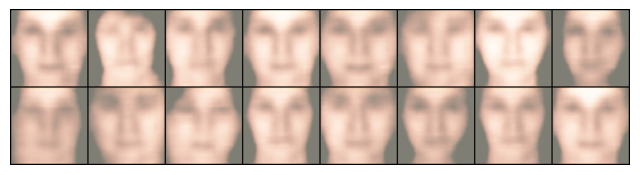

In [31]:
with torch.no_grad():
    mu, logvar = vae.encoder(real_imgs)
    z = vae.reparameterize(mu, logvar)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{Z_FOLDER}/z_from_real_imgs.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

In [41]:
# --- 4. Интерполяция между двумя точками ---
frames = []
with torch.no_grad():
    z1 = torch.randn(1, LATENT_DIM).to(DEVICE)
    z2 = torch.randn(1, LATENT_DIM).to(DEVICE)
    alphas = torch.linspace(0, 1, steps=30).unsqueeze(1).to(DEVICE)
    z = (1 - alphas) * z1 + alphas * z2
    for i, zi in enumerate(z):
        sample = vae.decoder(zi.unsqueeze(0))
        img_path = f'{MORPH_FOLDER}/frame_{i:03d}.png'
        vutils.save_image(sample.cpu(), img_path, nrow=1)
        frames.append(imageio.imread(img_path))
    imageio.mimsave(f'{MORPH_FOLDER}/morphing.gif', frames, fps=10)
    print("GIF морфинга сохранён как 'morphing.gif'")

GIF морфинга сохранён как 'morphing.gif'


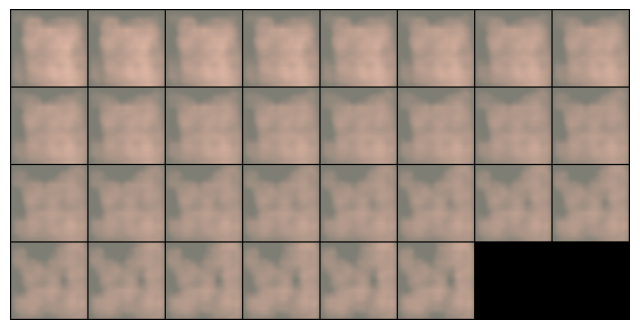

In [ ]:
# Показываем последний батч интерполяции
vutils.save_image(vae.decoder(z).cpu(), f'{Z_FOLDER}/z_interpolation.png', nrow=6)
imshow(torchvision.utils.make_grid(vae.decoder(z).cpu()))

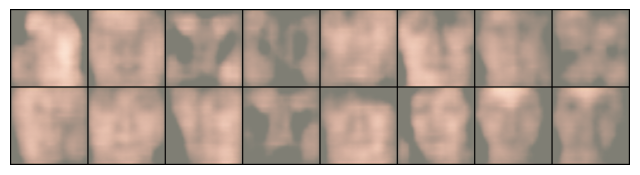

In [ ]:
# --- 5. Альтернативное распределение (равномерное) ---
with torch.no_grad():
    z = torch.empty(NUM_PIC, LATENT_DIM).uniform_(-2, 2).to(DEVICE)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{Z_FOLDER}/z_uniform_distribution.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

### Код для удобного подбора ручных признаков и генерации 2D-сетки лиц + анимация

In [35]:
# --- Настройки ---
GRID_SIZE = 8  # Сетка GRID_SIZE x GRID_SIZE
# Предполагаем, что модель VAE уже загружена и называется "vae"
vae.eval()

VAE(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(3, 6, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(6, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): ReLU()
    )
    (fc_mu): Linear(in_features=1536, out_features=128, bias=True)
    (fc_logvar): Linear(in_features=1536, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=128, out_features=1536, bias=True)
    (deconv): Sequential(
      (0): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4)

In [36]:
# --- Удобный подбор параметров ---
def generate_manual_z(fixed_value=0.0, vary_dims=(0, 1), range_min=-3, range_max=3, grid_size=GRID_SIZE):
    total = grid_size * grid_size
    z = torch.full((total, LATENT_DIM), fixed_value).to(DEVICE)
    values = torch.linspace(range_min, range_max, steps=grid_size)
    grid = torch.cartesian_prod(values, values)
    for idx, (val_x, val_y) in enumerate(grid):
        z[idx, vary_dims[0]] = val_x
        z[idx, vary_dims[1]] = val_y
    return z

In [37]:
# --- Генерация 2D-сетки лиц ---
def generate_face_grid(z, save_path=f'{GRID_FOLDER}/grid_faces.png', grid_size=GRID_SIZE):
    with torch.no_grad():
        samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), save_path, nrow=grid_size)
    print(f"Сетка лиц сохранена в {save_path}")
    imshow(torchvision.utils.make_grid(samples.cpu(), nrow=grid_size))

In [ ]:
# --- Анимация перемещения по латентному пространству ---
def generate_latent_animation(vary_dims=(0, 1), steps=30, fixed_value=0.0, range_min=-3, range_max=3, save_path='{OUTPUT}/latent_walk.gif'):
    frames = []
  
    with torch.no_grad():
        for step in range(steps):
            alpha = step / (steps - 1)
            val_x = (1 - alpha) * range_min + alpha * range_max
            val_y = np.sin(alpha * np.pi * 2) * (range_max / 2)

            z = torch.full((1, LATENT_DIM), fixed_value).to(DEVICE)
            z[0, vary_dims[0]] = val_x
            z[0, vary_dims[1]] = val_y

            sample = vae.decoder(z)
            img_path = f'{LAT_GRID}/frame_{step:03d}.png'
            vutils.save_image(sample.cpu(), img_path, nrow=1)
            frames.append(imageio.imread(img_path))

    imageio.mimsave(save_path, frames, fps=10)
    print(f"Анимация латентного перехода сохранена в {save_path}")

### Примеры использования

Сетка лиц сохранена в ./output\gridgrid_faces_0_1.png


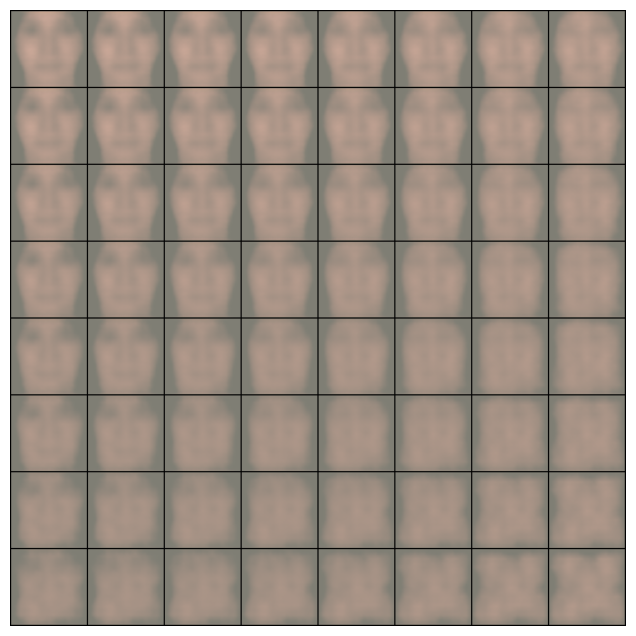

In [ ]:
# 1. Меняем 0-й и 1-й признак
z = generate_manual_z(fixed_value=0.0, vary_dims=(0, 1), range_min=-3, range_max=3)
generate_face_grid(z, save_path=f'{GRID_FOLDER}/grid_faces_0_1.png')

Сетка лиц сохранена в ./output\gridgrid_faces_2_3.png


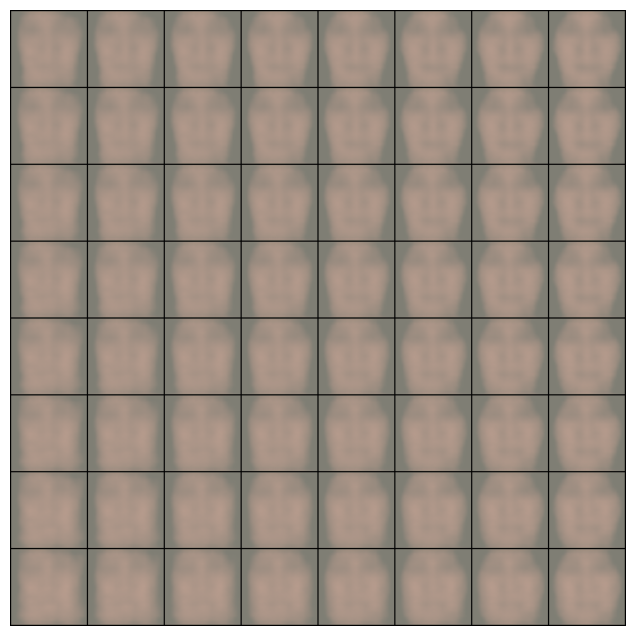

In [ ]:
# 2. Меняем 2-й и 3-й признак
z = generate_manual_z(fixed_value=0.0, vary_dims=(2, 3), range_min=-2, range_max=2)
generate_face_grid(z, save_path=f'{GRID_FOLDER}/grid_faces_2_3.png')



Сетка лиц сохранена в ./output\grid/grid_faces_5_6.png


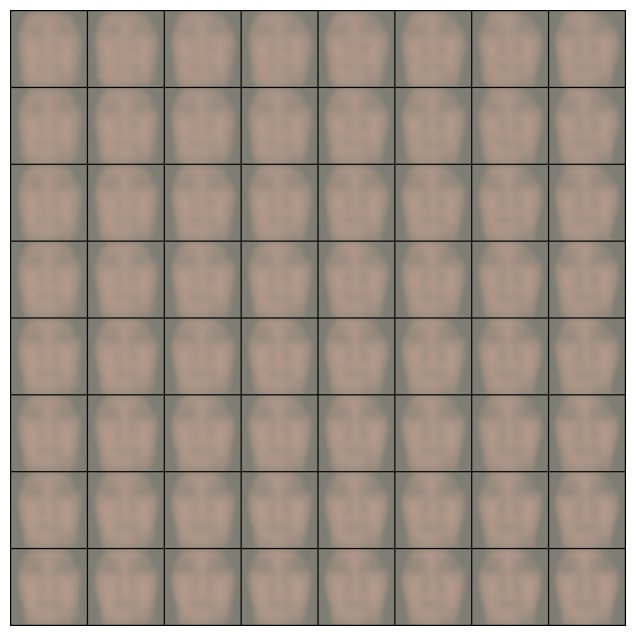

In [49]:
# 3. Узкий диапазон изменений для тонких вариаций
z = generate_manual_z(fixed_value=0.0, vary_dims=(5, 6), range_min=-1, range_max=1)
generate_face_grid(z, save_path=f'{GRID_FOLDER}/grid_faces_5_6.png')



In [48]:
# 4. Генерация анимации перемещения по латентному пространству
generate_latent_animation(vary_dims=(0, 1), steps=40, save_path=f'{OUTPUT}/latent_walk.gif')


Анимация латентного перехода сохранена в ./output/latent_walk.gif
